In [ ]:
!pip install toolz --quiet

In [16]:
import cv2
import requests
import numpy as np
import time
# from toolz.itertoolz import last

def loc_sys(img:np.ndarray) -> np.ndarray:
    # AREA_THRES = 1000.0
    AREA_THRES=100.0
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # preprocess
    # kernel = np.ones((5,5), np.uint8)
    # img_erosion = cv2.erode(img, kernel, iterations=2)
    frame_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # (2, 29), (54, 255), (74, 255)
    # 8 116 102
    # 20 252 210
    frame_threshold = cv2.inRange(frame_HSV, (0, 100, 75), (30, 255, 255))
    # processed_img2 = cv2.bitwise_and(img,img, mask=frame_threshold)
    # get contours
    cnts = cv2.findContours(frame_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    # # find contour with max area
    # max = 0
    # idx = -1
    # for i,c in enumerate(cnts):
    #     area = cv2.contourArea(c)
    #     if area > max:
    #         idx = i
    #         max = area
    # blue_box = cnts[idx]
    x = None
    y = None
    if len(cnts) > 0:
        blue_box = max(cnts, key = cv2.contourArea)
        if cv2.contourArea(blue_box) > AREA_THRES:
            # return its center point
            x,y,w,h = cv2.boundingRect(blue_box)
            x = x+w/2
            y = y+h/2
    #f_img = cv2.drawContours(processed_img2, [blue_box], -1, (255,0,0), 2)
    #plt.figure(figsize=(12,12))
    #plt.imshow(f_img[100:200,350:450])
    return x,y

In [25]:
count=0
skip_count = 10
r = requests.get('http://10.20.2.114/asp/video.cgi', auth=('admin', 'admin'), stream=True)
coord_arrx=[]
coord_arry=[]
if(r.status_code == 200):
    bytes1 = bytes()
    for idx, chunk in enumerate(r.iter_content(chunk_size=100000)):
        count+=1
        bytes1 += chunk
        a = bytes1.find(b'\xff\xd8')
        b = bytes1.find(b'\xff\xd9')
        if idx < skip_count:
            continue
        if a != -1 and b != -1:
            if count%1==0:
                # t1 = time.time()
                jpg = bytes1[a:b+2]
                bytes1 = bytes1[b+2:]
                i = cv2.imdecode(np.fromstring(jpg, dtype=np.uint8), cv2.IMREAD_COLOR)
                # specify desired output size 
                width = 720
                height = 1280
                # specify conjugate x,y coordinates (not y,x)
                input = np.float32([[0,366], [582, 51], [1257,66], [788,715]])
                output = np.float32([[0,0], [width-1,0], [width-1,width-1], [0,width-1]])

                # compute perspective matrixbytes1 = bytes1[b+2:]
                i = cv2.imdecode(np.fromstring(jpg, dtype=np.uint8), cv2.IMREAD_COLOR)
                # specify desired output size 
                width = 720
                # height = 1280
                matrix = cv2.getPerspectiveTransform(input,output)

                # do perspective transformation setting area outside input to black
                imgOutput = cv2.warpPerspective(i, matrix, (width,width), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
                
                font = cv2.FONT_HERSHEY_SIMPLEX 
                x,y = loc_sys(imgOutput)
                if x and y:
                    org=[int(x),int(y)]
                    if x > 500:
                        org[0] = 500
                    if y > 650:
                        org[1] = 650
                    fontScale = 0.8
                    color = (0, 0, 255)
                    thickness = 2

                    # Using cv2.putText() method
                    imgOutput = cv2.putText(imgOutput, f"car({(6*x/720):.2f},{(6*y/720):.2f})", org, font,
                                                       fontScale, color, thickness, cv2.LINE_AA)
                    coord_arrx.append(6*x/720)
                    coord_arry.append(6*y/720)
                # print(org)
                cv2.imshow('Track Image', imgOutput)
                # print(time.time() - t1)
                # cv2.imshow("Loc", f_img)
                # cv2.imwrite("TrackImageToday.png",imgOutput)
            key=cv2.waitKey(1) 
            if key == 27 or key ==113:
                cv2. destroyAllWindows()
                break
            else:
                if key!=-1:
                    print(key)
                pass
                
else:
    print("Received unexpected status code {}".format(r.status_code))

/tmp/ipykernel_4547/4270570651.py:20: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  i = cv2.imdecode(np.fromstring(jpg, dtype=np.uint8), cv2.IMREAD_COLOR)
/tmp/ipykernel_4547/4270570651.py:29: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  i = cv2.imdecode(np.fromstring(jpg, dtype=np.uint8), cv2.IMREAD_COLOR)
QObject::moveToThread: Current thread (0x5570f582aa80) is not the object's thread (0x5570f5891100).
Cannot move to target thread (0x5570f582aa80)

QObject::moveToThread: Current thread (0x5570f582aa80) is not the object's thread (0x5570f5891100).
Cannot move to target thread (0x5570f582aa80)

QObject::moveToThread: Current thread (0x5570f582aa80) is not the object's thread (0x5570f5891100).
Cannot move to target thread (0x5570f582aa80)

QObject::moveToThread: Current thread (0x5570f582aa80) is not the obj

In [ ]:
import cv2
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
img=cv2.imread("TrackImage.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB )
# cv2.imshow("tm",img)
# key=cv2.waitKey(0) 


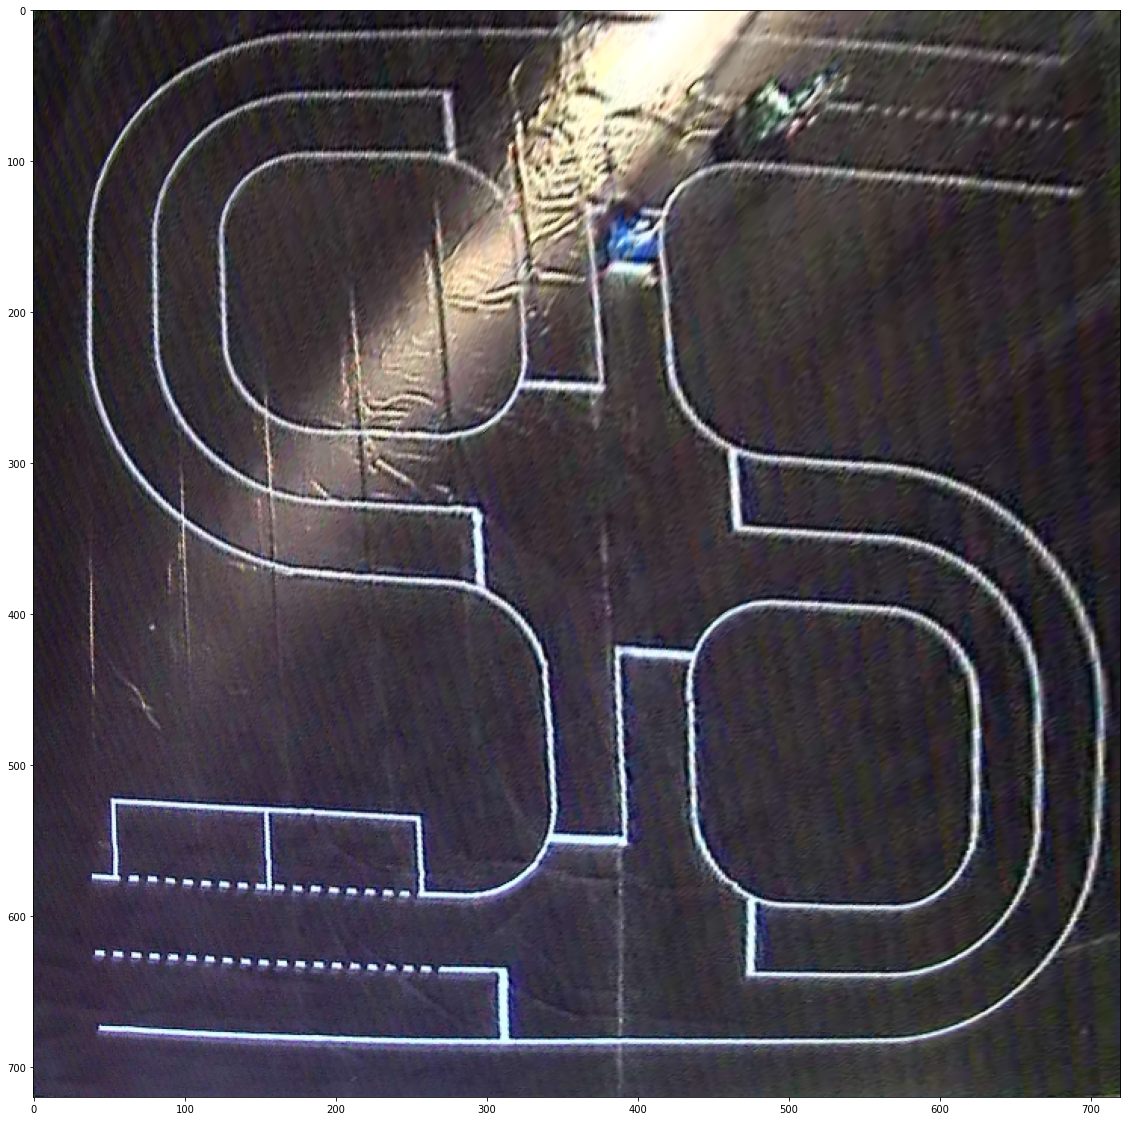

In [11]:
plt.figure(figsize=(20,20))
plt.imshow(img)

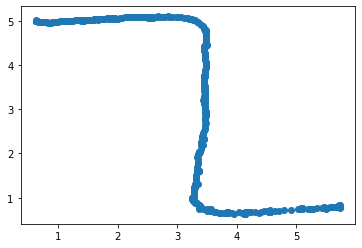

In [31]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
plt.scatter(coord_arrx,coord_arry)

import joblib

path_dict=joblib.dump({
    "x":coord_arrx,
    "y":coord_arry
},"test_path.z")

In [13]:
import cv2
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
img=cv2.imread("TrackImage2.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB )
# cv2.imshow("tm",img)
# key=cv2.waitKey(0) 

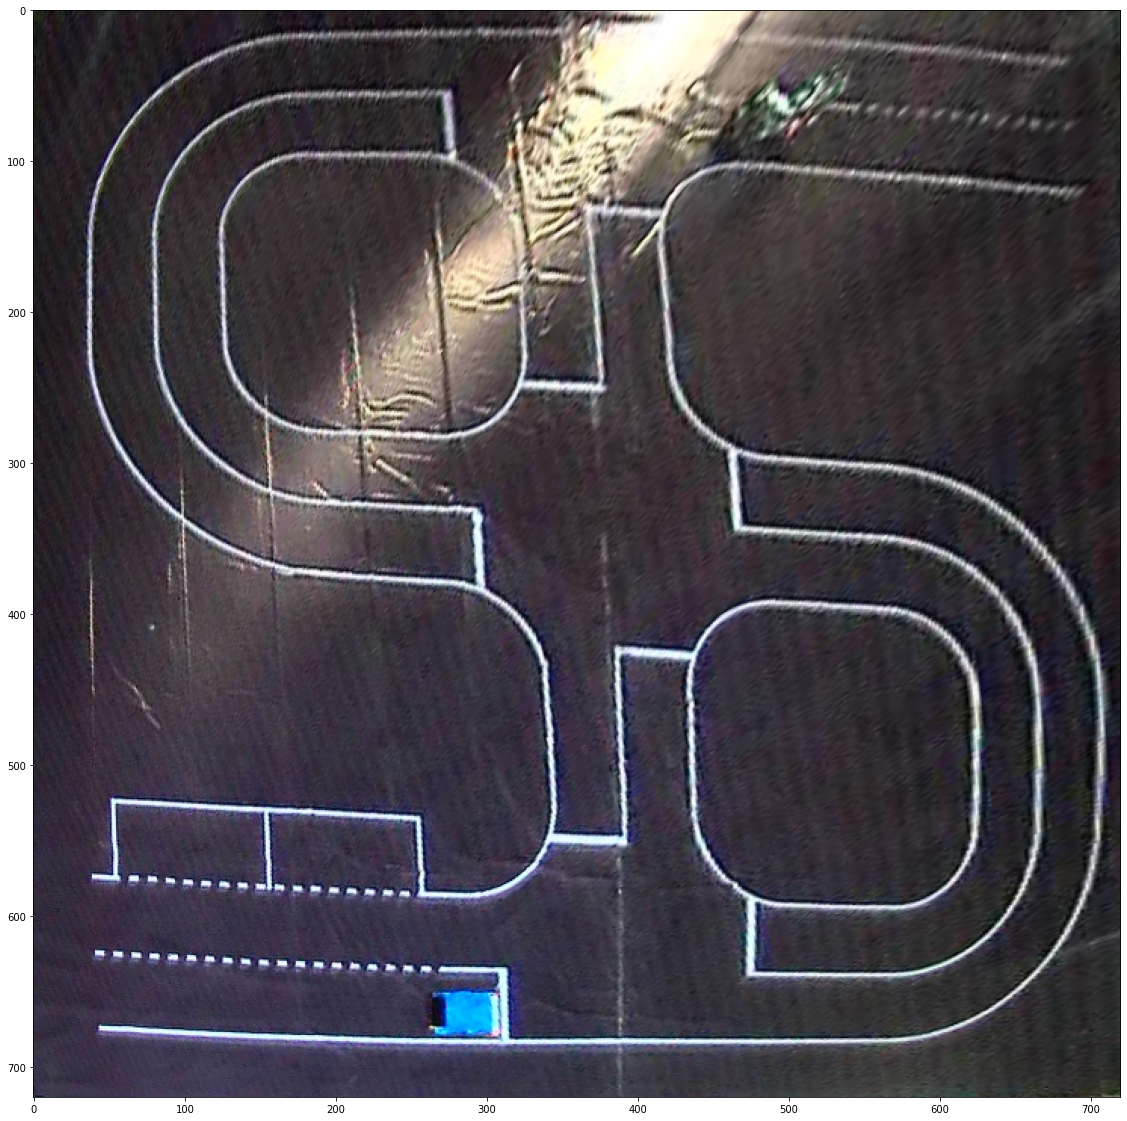

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(img)

### Just in Case thing dont work out 

In [3]:
import os
import cv2 as cv
from matplotlib import pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import numpy as np

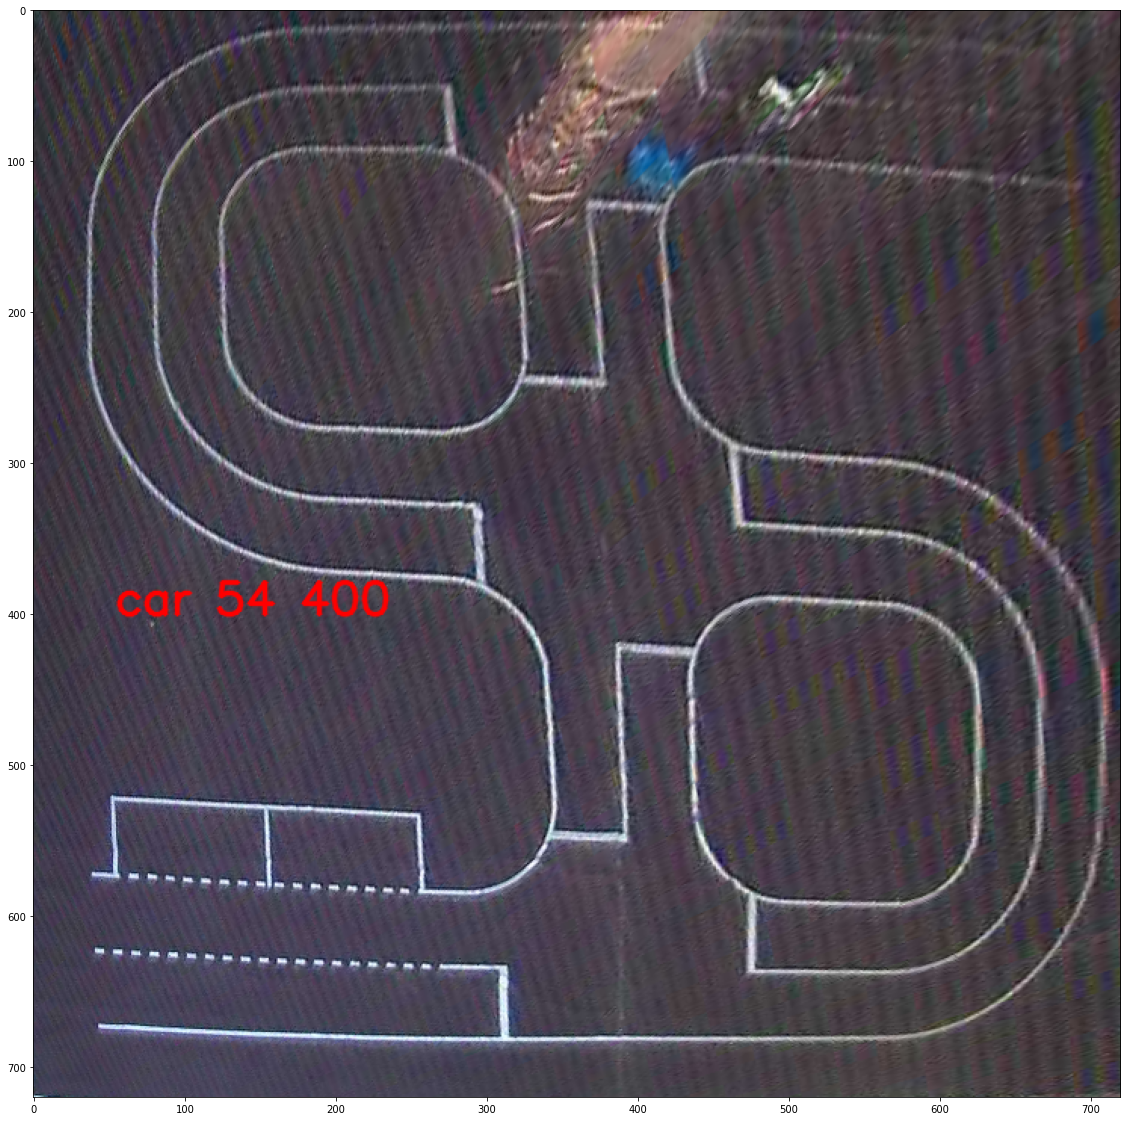

In [7]:
img1 = cv.imread("TrackImage.png")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

plt.figure(figsize= (20,20))
plt.imshow(img1)

8 116 102
20 252 210


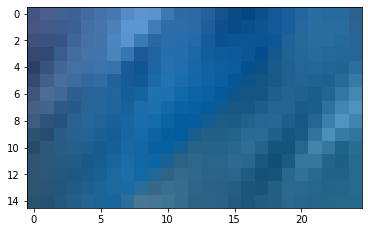

In [26]:
#plt.figure(figsize=(20,20))
from pprint import pprint
plt.imshow(img1[95:110,395:420,:])
frame_HSV = cv.cvtColor(img1, cv.COLOR_BGR2HSV)
section = frame_HSV[95:110,395:420]
print(np.min(section[:,:,0]),np.min(section[:,:,1]), np.min(section[:,:,2]))
print(np.max(section[:,:,0]),np.max(section[:,:,1]), np.max(section[:,:,2]))

# pprint(frame_HSV[160:168,400:410,:])

In [3]:
frame_threshold = cv.inRange(frame_HSV, (0, 150, 120), (30, 200, 200))
plt.imshow(frame_threshold)

NameError: name 'cv' is not defined

In [4]:
def get_contour(img:np.ndarray) -> np.ndarray:
    kernel = np.ones((5,5), np.uint8)
    img_erosion = cv.erode(img, kernel, iterations=2)
    frame_HSV = cv.cvtColor(img_erosion, cv.COLOR_BGR2HSV)
    # (2, 29), (54, 255), (74, 255)
    frame_threshold = cv.inRange(frame_HSV, (2, 40, 74), (30, 255, 255))
    return frame_threshold

NameError: name 'np' is not defined

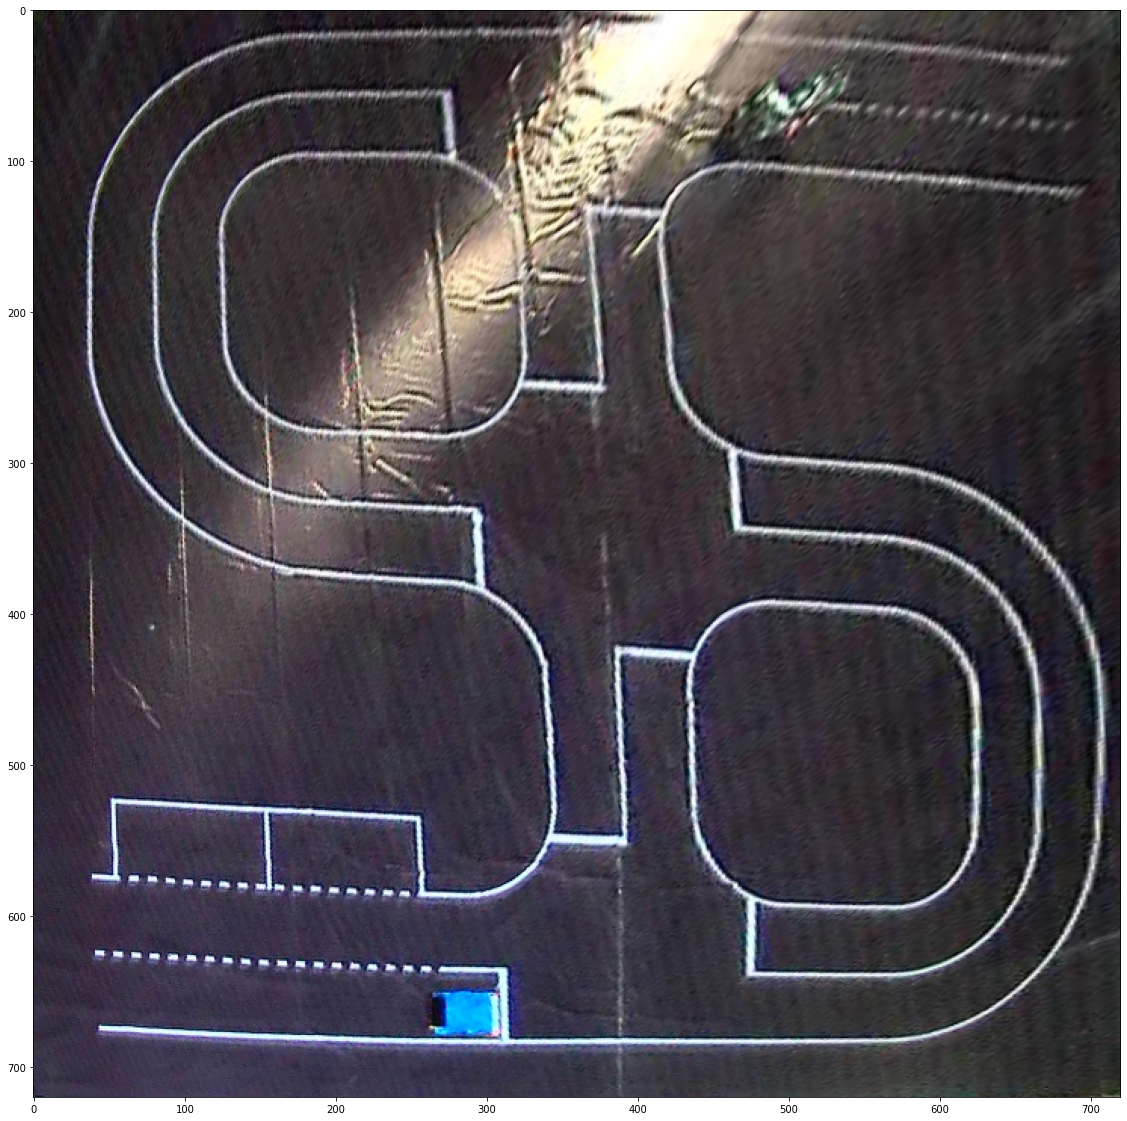

In [129]:
img2 = cv.imread("TrackImage2.png")
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(img2)

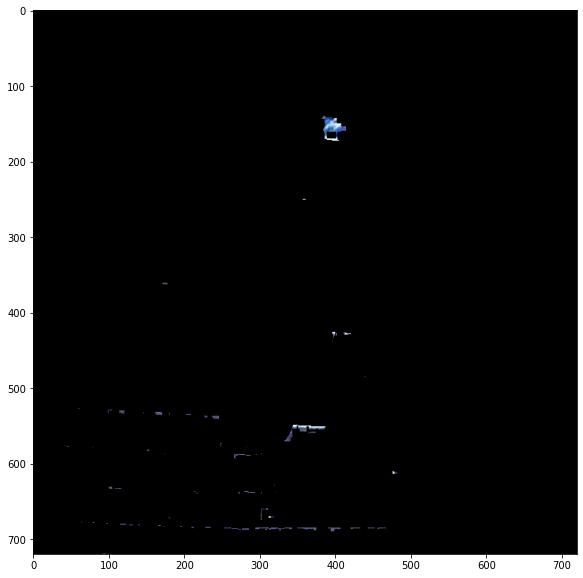

In [139]:
plt.figure(figsize=(10,10))
mask = get_contour(img1)
processed_img2 = cv.bitwise_and(img1,img1, mask=mask)
plt.imshow(processed_img2)


In [157]:
cnts = cv.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]


(382, 140)


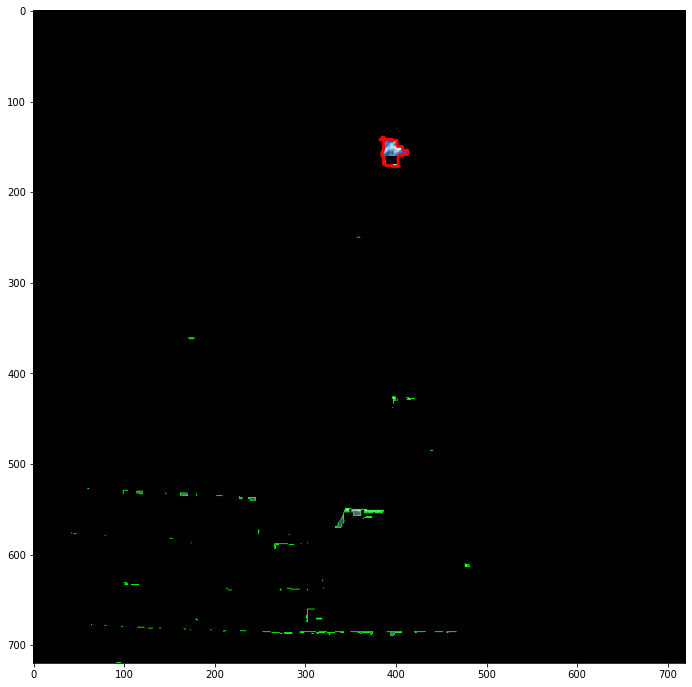

In [163]:
img = cv2.drawContours(processed_img2, cnts, -1, (0,255,0), 1)
max = 0
idx = -1
for i,c in enumerate(cnts):
    area = cv.contourArea(c)
    if area > max:
        idx = i
        max = area
blue_box = cnts[idx]
x,y,w,h = cv2.boundingRect(blue_box)
f_img = cv2.drawContours(processed_img2, [blue_box], -1, (255,0,0), 2)
plt.figure(figsize=(12,12))
plt.imshow(f_img)
print((x,y))

In [170]:
def loc_sys(img:np.ndarray) -> np.ndarray:
    # preprocess
    kernel = np.ones((5,5), np.uint8)
    img_erosion = cv.erode(img, kernel, iterations=2)
    frame_HSV = cv.cvtColor(img_erosion, cv.COLOR_BGR2HSV)
    # (2, 29), (54, 255), (74, 255)
    frame_threshold = cv.inRange(frame_HSV, (2, 40, 74), (30, 255, 255))
    processed_img2 = cv.bitwise_and(img1,img1, mask=frame_threshold)
    # get contours
    cnts = cv.findContours(frame_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    # find contour with max area
    max = 0
    idx = -1
    for i,c in enumerate(cnts):
        area = cv.contourArea(c)
        if area > max:
            idx = i
            max = area
    blue_box = cnts[idx]
    # return its center point
    x,y,w,h = cv2.boundingRect(blue_box)
    # f_img = cv2.drawContours(processed_img2, [blue_box], -1, (255,0,0), 2)
    # plt.figure(figsize=(12,12))
    # plt.imshow(f_img[100:200,350:450])
    return (x+w/2,y+h/2)

(398.0, 156.5)

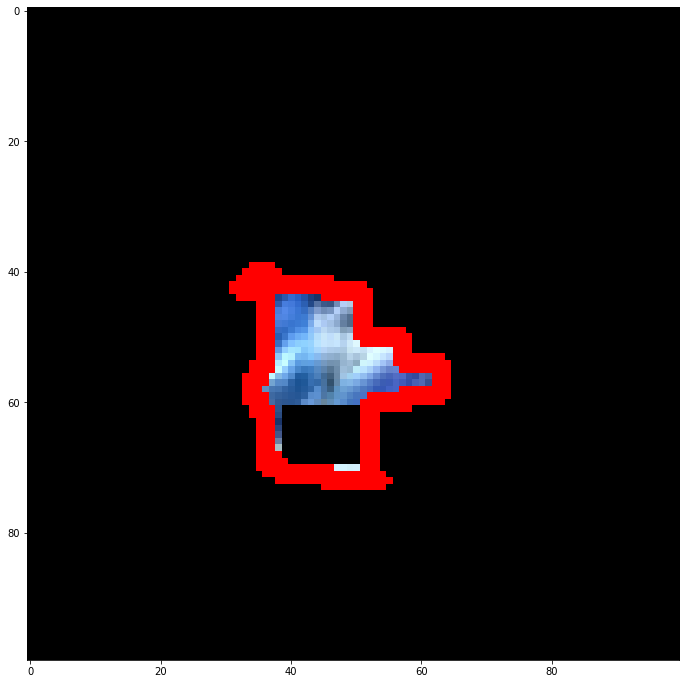

In [171]:
img1 = cv.imread("TrackImage.png")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
loc_sys(img1)

In [4]:
# cv2.VideoCapture('http://10.20.2.114/asp/video.cgi')

[ERROR:0] global ../modules/videoio/src/cap.cpp (140) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.5.1) ../modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): http://10.20.2.114/asp/video.cgi in function 'icvExtractPattern'




<VideoCapture 0x7f6cc7de3e70>